In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Project Name:** Petrol Price Forecasting  using Tensor Flow and Auto Keras

### In this project we will try to forecast the different petrol prices for the upcoming dates given to us.

### I'll use LSTM and ARIMA forecasting models to predict the prices then implement the same using Auto Keras, which is an Auto ML Library.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/ML_Projects/Petrol_Price_Forecasting_Keras/train_data.csv")

In [4]:
df_train.head()

,Date,Petrol (USD)
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28


In [5]:
null_counts = df_train.isnull().sum()
null_counts

Date            0
Petrol (USD)    2
dtype: int64

In [6]:
df_train = df_train.dropna()

In [7]:
len(df_train)

811

In [8]:
df_train.rename(columns={"Petrol (USD)": "Petrol"}, inplace=True)
df_train.head()

,Date,Petrol
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28


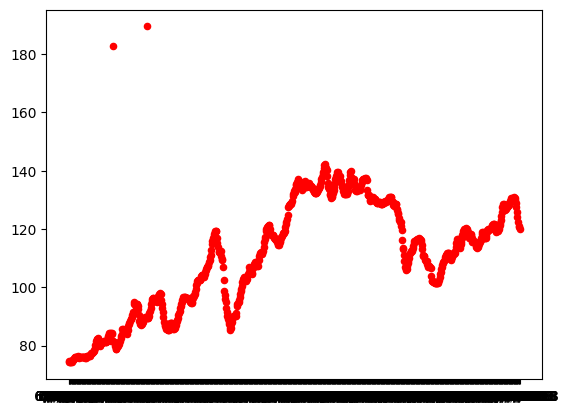

In [9]:
plt.scatter(df_train.Date, df_train.Petrol, color='red', label='Prices', s=20)

In [10]:
#Removing outliers
df_train = df_train[df_train.Petrol < 170]

In [11]:
df_train = df_train.reset_index()['Petrol']
df_train.head()

0    74.59
1    74.47
2    74.42
3    74.35
4    74.28
Name: Petrol, dtype: float64

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
df_train_scaled = scaler.fit_transform(np.array(df_train).reshape(-1,1))

In [13]:
training_size = int(len(df_train_scaled) * 0.7)
testing_size = len(df_train_scaled) - training_size

train_data, test_data = df_train_scaled[0:training_size,:], df_train_scaled[training_size:len(df_train_scaled),:1]

In [14]:
print(train_data.size)
print(test_data.size)

566
243


**Data Preprocessing**

In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [16]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [17]:
print(X_train.shape)
print(y_train.shape)

(465, 100)
(465,)


In [18]:
X_train

array([[0.00559152, 0.00382578, 0.00309005, ..., 0.16627428, 0.16524426,
        0.1640671 ],
       [0.00382578, 0.00309005, 0.00206004, ..., 0.16524426, 0.1640671 ,
        0.16274279],
       [0.00309005, 0.00206004, 0.00103002, ..., 0.1640671 , 0.16274279,
        0.15538552],
       ...,
       [0.94290759, 0.90582696, 0.8852266 , ..., 0.79988228, 0.80267805,
        0.80194232],
       [0.90582696, 0.8852266 , 0.8806651 , ..., 0.80267805, 0.80194232,
        0.80459094],
       [0.8852266 , 0.8806651 , 0.87492643, ..., 0.80194232, 0.80459094,
        0.80782813]])

In [19]:
y_train

array([0.16274279, 0.15538552, 0.14670394, 0.14420247, 0.15862272,
       0.16642142, 0.18422602, 0.19540906, 0.19894055, 0.21100647,
       0.21762802, 0.22130665, 0.22748676, 0.2405827 , 0.24367275,
       0.2532372 , 0.29664509, 0.30694526, 0.29723367, 0.28134197,
       0.28399058, 0.29487934, 0.29326074, 0.283402  , 0.26868746,
       0.24014126, 0.21188935, 0.19334903, 0.19334903, 0.19114185,
       0.19643908, 0.20114773, 0.20335491, 0.21115362, 0.21777516,
       0.22572101, 0.23057681, 0.22836963, 0.22719247, 0.22645674,
       0.2230724 , 0.22572101, 0.23513832, 0.24941142, 0.25853443,
       0.27310182, 0.29458505, 0.31106533, 0.32254267, 0.32739847,
       0.32636845, 0.32210124, 0.31121248, 0.30944673, 0.31312537,
       0.31238964, 0.30547381, 0.30988817, 0.31606828, 0.33357858,
       0.34682166, 0.34755739, 0.35079459, 0.34741024, 0.316804  ,
       0.29708652, 0.27472042, 0.25412007, 0.22910536, 0.20585639,
       0.18746321, 0.18231313, 0.17216009, 0.16965862, 0.16759

**LSTM**

In [20]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 269ms/step - loss: 0.2239 - val_loss: 0.0477
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - loss: 0.0283 - val_loss: 0.0232
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 0.0212 - val_loss: 0.0067
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 0.0140 - val_loss: 0.0029
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - loss: 0.0098 - val_loss: 0.0018
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 0.0062 - val_loss: 0.0019
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.0061 - val_loss: 0.0019
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - loss: 0.0059 - val_loss: 0.0022
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - loss: 0.0

In [23]:
### making predictions and checking performance metrics
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [ ]:
##Transformback to original form
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

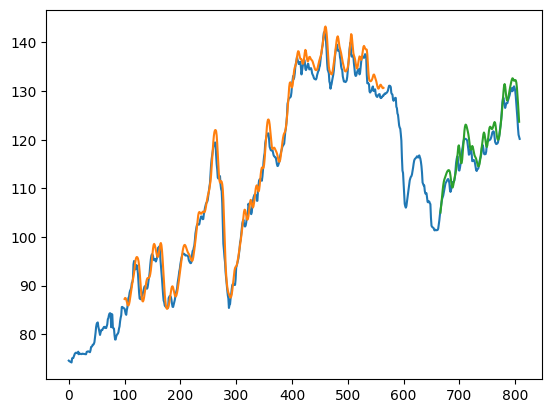

In [25]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df_train_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predictions)+look_back, :] = train_predictions
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_train_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predictions)+(look_back*2)+1:len(df_train_scaled)-1, :] = test_predictions
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_train_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/ML_Projects/Petrol_Price_Forecasting_Keras/test_data.csv")
df_test.head()

In [27]:
model.save("/content/drive/MyDrive/ML_Projects/Petrol_Price_Forecasting_Keras/petrol_price_prediction_model.h5")

**ARIMA**

In [28]:
!pip install --upgrade patsy

In [29]:
!pip install statsmodels

In [30]:
!pip install --upgrade --no-deps statsmodels

In [31]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from math import sqrt

In [32]:
df = pd.read_csv("/content/drive/MyDrive/ML_Projects/Petrol_Price_Forecasting_Keras/train_data.csv")
df.head()

,Date,Petrol (USD)
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28


In [33]:
df.rename(columns={"Petrol (USD)": "Petrol"}, inplace = True)
df.head()

,Date,Petrol
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28


In [34]:
df = df.dropna()
df = df[df.Petrol<160]
df.head()

,Date,Petrol
0,6/9/2003,74.59
1,6/16/2003,74.47
2,6/23/2003,74.42
3,6/30/2003,74.35
4,7/7/2003,74.28


In [35]:
df = df.reset_index()['Petrol']
df.head()

0    74.59
1    74.47
2    74.42
3    74.35
4    74.28
Name: Petrol, dtype: float64

In [36]:
model_arima = ARIMA(df.values, order=(5,1,0))
model_fit_arima = model_arima.fit()
output_arima = model_fit_arima.forecast(steps=30)

In [37]:
output_arima

array([119.80670599, 119.52143354, 119.30634698, 119.14818605,
       119.02925494, 118.93899217, 118.87071727, 118.81917633,
       118.78030453, 118.75097725, 118.72884028, 118.71213018,
       118.69951765, 118.6899984 , 118.68281381, 118.67739118,
       118.6732984 , 118.67020932, 118.66787782, 118.66611809,
       118.66478993, 118.66378748, 118.66303088, 118.66245982,
       118.66202882, 118.66170351, 118.66145798, 118.66127267,
       118.6611328 , 118.66102723])

# Using Auto ML
 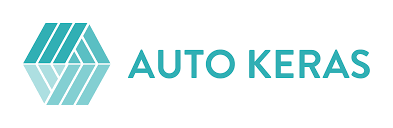


In [ ]:
!pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc1

In [ ]:
!pip install autokeras

In [ ]:
!pip show autokeras

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import autokeras as ak

In [ ]:
reg = ak.StructuredDataRegressor(overwrite=True, max_trials=3)

In [ ]:
reg.fit(x=X_train, y=y_train, verbose=0)

In [ ]:
# Evvaluate the model
mae, _  = reg.evaluate(X_test, y_test, verbose=0)
print('MAE: %.3f' % mae)

# use the model to make a prediction
yhat_test = reg.predict(X_test)

# get the best performing model
model = reg.export_model()

In [ ]:
# summarize the loaded model
model.summary()

In [ ]:
yhat_train= reg.predict(X_train)

In [ ]:
train_predict = scaler.inverse_transform(yhat_train)
test_predict = scaler.inverse_transform(yhat_test)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test,yhat_test)

In [ ]:
mean_squared_error(y_train,yhat_train)